In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 21.2 Data generation

In [2]:
np.random.seed(123456)
n_site = 200
vege = np.sort(st.uniform.rvs(-1.5, 3, size = n_site))
alpha_lam = 2
beta1_lam = 2
beta2_lam = -2
lam = np.exp(alpha_lam + beta1_lam * vege + beta2_lam * vege**2)
N = st.poisson.rvs(lam, size = n_site)

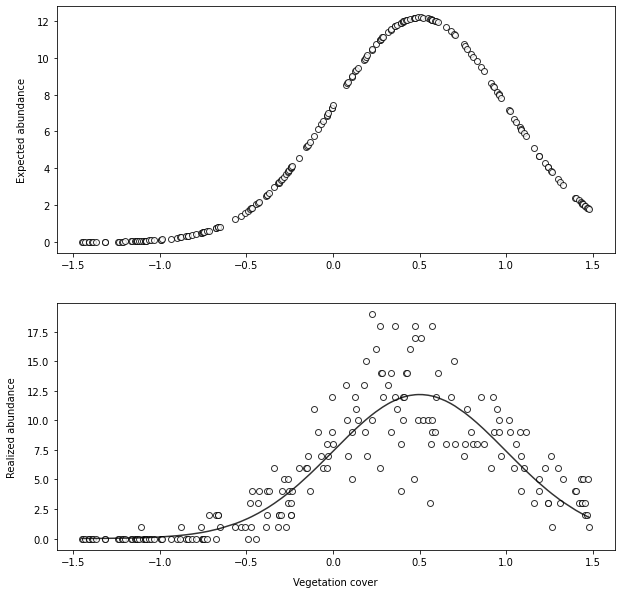

In [3]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = False)
ax[0].scatter(vege, lam, color = 'k', alpha = 0.8, facecolor = 'white')
ax[0].set_ylabel('Expected abundance', fontsize = 10, labelpad = 10)

ax[1].scatter(vege, N, color = 'k', alpha = 0.8, facecolor = 'white')
ax[1].plot(vege, lam, color = 'k', alpha = 0.8)
ax[1].set_xlabel('Vegetation cover', fontsize = 10, labelpad = 10)
ax[1].set_ylabel('Realized abundance', fontsize = 10, labelpad = 10); 

In [4]:
alpha_p = 1
beta_p = -4
det_prob = np.exp(alpha_p + beta_p * vege) / (1 + np.exp(alpha_p + beta_p * vege))
expected_count = N * det_prob

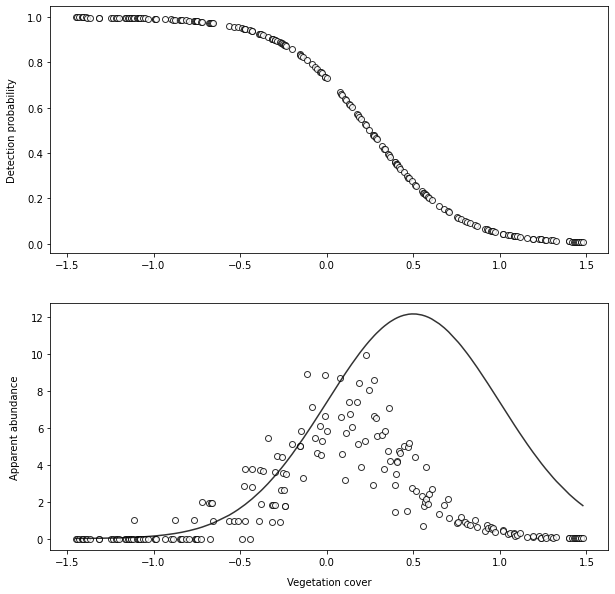

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = False)
ax[0].scatter(vege, det_prob, color = 'k', alpha = 0.8, facecolor = 'white')
ax[0].set_ylabel('Detection probability', fontsize = 10, labelpad = 10)

ax[1].scatter(vege, expected_count, color = 'k', alpha = 0.8, facecolor = 'white')
ax[1].plot(vege, lam, color = 'k', alpha = 0.8)
ax[1].set_xlabel('Vegetation cover', fontsize = 10, labelpad = 10)
ax[1].set_ylabel('Apparent abundance', fontsize = 10, labelpad = 10); 

In [6]:
R = n_site
T = 10
y = np.zeros((R, T))
for i in range(T):
    y[:, i] = st.binom.rvs(N, det_prob, size = n_site)
    
C  = y.flatten('C')
site_p = np.repeat(range(1, R + 1), T)
vege_p = np.repeat(vege, T)

In [7]:
max_count = np.max(y, axis = 1)
data = {'max_count': max_count, 'vege': vege, 'vege2': vege**2}
naive_analysis = smf.glm("max_count ~ vege + vege2", data = data, family = sm.families.Poisson()).fit()
print(naive_analysis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              max_count   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.00
Date:                Mon, 08 Aug 2022   Deviance:                       136.53
Time:                        22:17:03   Pearson chi2:                     155.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9527
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9114      0.050     37.874      0.0

In [8]:
lin_pred = naive_analysis.params[0] + naive_analysis.params[1] * vege + naive_analysis.params[2] * vege**2

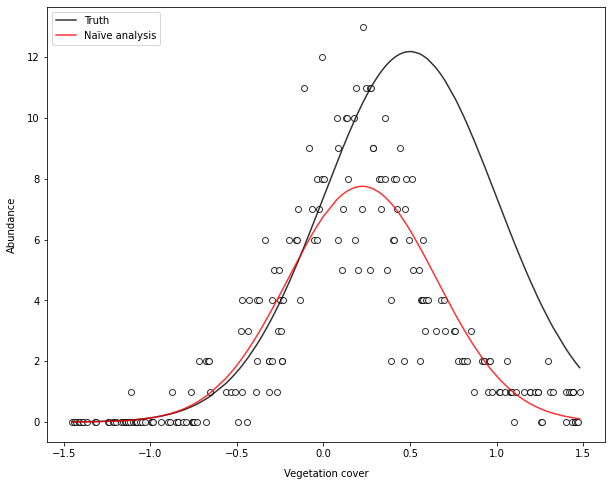

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax.scatter(vege, max_count, color = 'k', alpha = 0.8, facecolor = 'white')
ax.plot(vege, lam, color = 'k', alpha = 0.8, label = 'Truth')
ax.plot(vege, np.exp(lin_pred), color = 'red', alpha = 0.8, label = 'Naïve analysis')
ax.set_ylabel('Abundance', fontsize = 10, labelpad = 10)
ax.set_xlabel('Vegetation cover', fontsize = 10, labelpad = 10)
ax.legend(loc = 'upper left');

### 21.3 Analysis using PyMC3

In [10]:
# To do